In [1]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
raw_dir = '/home/grace/Documents/python/ttc_exclusions/data/raw/'
figures_dir = '/home/grace/Documents/python/ttc_exclusions/reports/figures/'

'Copy of ELSIE DR.xlsx'
 ELISE_270919.xlsx
 elise_txpts.png
 ELISE.xlsx
'ELSIE Uploaded Compound List.docx'
 Exclusions_Dashboard_100619.xlsx
 Exclusions_FDA_100619.csv
 FDA_COC.xlsx
 genetox_structural_alerts_140819.xlsx
 HPC_230719.xlsx
 ISO_TS_21726_2019.pdf
 ISS_carc.csv
 kroes_gentox_alerts_120619.xlsx
 LRIexclusions_180719_4toxtree_outputgentox.csv
 LRI_TTC_updated_090719.csv
 LRI_TTC_updated_180719.csv
 lri_txps_140220.xlsx
 lri_txps.tsv
 toxprint_v2_vs_lri_all_4txps_wosalts.tsv


In [6]:
lri = pd.read_csv(raw_dir+'LRI_TTC_updated_180719.csv')

In [7]:
lri.DTXSID.nunique()

45038

In [8]:
lri.mark_ttc_class.unique()

array(['Genotoxicity Alert', 'Class III', 'NA for TTC', 'OP/Carbamate',
       'Class I', nan, 'Class II'], dtype=object)

In [9]:
exclusions = lri[lri.mark_ttc_class == 'NA for TTC']

In [10]:
len(exclusions)

4002

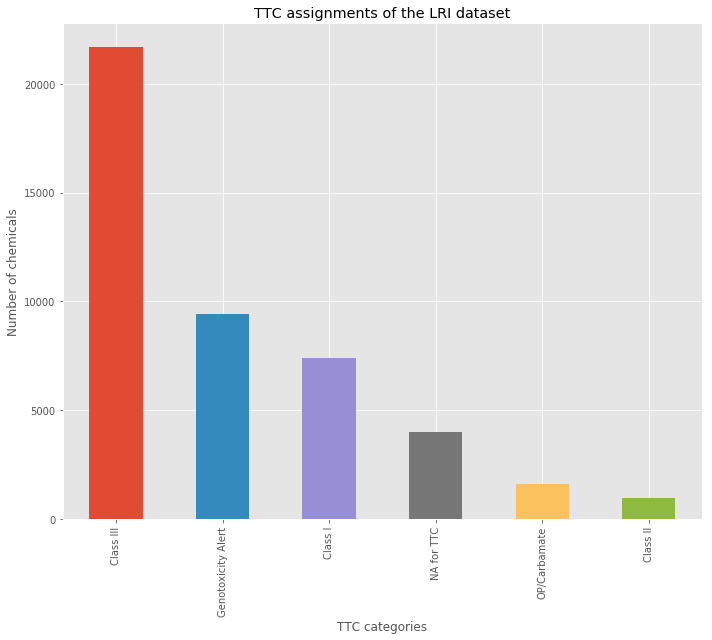

In [16]:
plt.style.use('ggplot')
plt.figure(figsize = (10,9))
plt.title('TTC assignments of the LRI dataset')
plt.xlabel('TTC categories')
plt.ylabel('Number of chemicals')
lri.mark_ttc_class.value_counts().plot.bar()
plt.tight_layout()
plt.savefig(figures_dir+'TTC_category_counts.png', dpi = 300)

In [19]:
lri.mark_ttc_class.count()


45017

In [20]:
exclusions.reason_for_NA.value_counts()

Yes to Q1                  3759
High Potency Carcinogen     241
Steroid                       2
Name: reason_for_NA, dtype: int64

In [21]:
def has_metal_atom(smiles):
    metal_dict = {'Na': 11 , 'Mg': 12, 'Si': 14, 'K':19, 'Ca':20, 'Mn':25, 'Fe':26, 'Cu':29, 'Zn':30, 'Co':27, 'Ni':28, 'As': 33, 'Cr':24, 'Hg':80, 'Pb':82, 'V':23, 'Al':13, 'Ag':47, 'Cd':48, 'B':5, 'Ti': 22, 'Se': 34, 'Sn': 50, 'Sb':51, 'Be': 4, 'Zr': 40, 'Nb': 41, 'Mo': 42, 'Te':52, 'Ba':56, 'W':74, 'Au': 79, 'Bi': 83}
    essential_metal_dict = {'Na': 11 , 'K':19,'Mg': 12,  'Ca':20, 'Fe':26,  'Mn':25, 'Co':27, 'Cu':29, 'Zn':30, 'Mo': 42}
    mol = Chem.MolFromSmiles(smiles)
    if mol  is None:
        return False
    return any(atom for atom in mol.GetAtoms() if atom.GetAtomicNum() in list(metal_dict.values()))

In [22]:
#https://www.sciencedirect.com/science/article/pii/S0162013418306846
#essential metals
#Na, K, Mg, Ca, Fe, Mn, Co, Cu, Zn and Mo
    

In [23]:
len([has_metal_atom(e) for e in exclusions['smiles']])

4002

In [24]:
def metal_ions(smiles):
    essential_metal = ['[Na+]', '[K+]', '[Mg++]',  '[Ca++]', '[Fe+3]',  '[Mn++]', '[Co+]', '[Cu++]', '[Zn++]', '[Mo++]']
    mol = Chem.MolFromSmiles(smiles)
    if mol  is None:
        return False
    return any(mol.HasSubstructMatch(Chem.MolFromSmarts(e)) for e in essential_metal)

In [25]:
def P_inorg(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol  is None:
        return False
    return mol.HasSubstructMatch(Chem.MolFromSmarts('[OH]P(=[O])([OH])[OH]'))

In [26]:

m = Chem.MolFromSmiles('[Na+].[Na+].Nc1cc(cc2cc(c(N=Nc3ccccc3)c(O)c12)S([O-])(=O)=O)S([O-])(=O)=O')
m.HasSubstructMatch(Chem.MolFromSmarts('[Na+]'))


True

In [27]:
len([metal_ions(x) for x in exclusions['smiles']])

4002

In [28]:
#df2 = exclusions[res]
#print(len(df2))

In [29]:
#df2.head()

In [30]:

#without_ions = exclusions[~exclusions.index.isin(df2.index)]

In [31]:
metal_salt = []
for x in exclusions['smiles']:
    is_metal_salt = metal_ions(x)
    metal_salt.append(is_metal_salt)
exclusions['metal_salts'] = metal_salt

/home/grace/anaconda3/envs/my-mordred/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [32]:
metals = []
for x in exclusions['smiles']:
    is_inorg = has_metal_atom(x)
    metals.append(is_inorg)
exclusions['inorgs'] = metals

/home/grace/anaconda3/envs/my-mordred/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [33]:
isP_inorg = []
for x in exclusions['smiles']:
    is_P = P_inorg(x)
    isP_inorg.append(is_P)
exclusions['inorgP'] = isP_inorg

/home/grace/anaconda3/envs/my-mordred/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [34]:
exclusions.head()

,casrn,DTXSID,name,smiles,daily_intake,iris_noael,tox_cast_oed_5th,tox_cast_oed_median,tox_tree_ttc,ttc_class,kroes_decision,small_httk,large_cerapp,mark_ttc_class,reason_for_NA,old_ttc_class,metal_salts,inorgs,inorgP
8,3520-42-1,DTXSID7021235,C.I. Acid Red 52,[Na+].CCN(CC)c1cc2[o+]c3cc(N(CC)CC)c(C)cc3c(-c...,99,NaN,NaN,NaN,0.000003,Genotoxicity Alert,Risk assessment requires compound-specific tox...,NO,YES,NA for TTC,Yes to Q1,NA for TTC,True,True,False
10,16423-68-0,DTXSID7021233,FD&C Red 3,[Na+].[Na+].[O-]C(=O)c1ccccc1-c1c2cc(I)c([O-])...,99,NaN,NaN,NaN,0.000003,Genotoxicity Alert,Risk assessment requires compound-specific tox...,NO,YES,NA for TTC,Yes to Q1,NA for TTC,True,True,False
13,4474-24-2,DTXSID2041705,C.I. Acid Blue 80,[Na+].[Na+].Cc1cc(C)c(c(C)c1Nc1ccc(Nc2c(C)cc(C...,99,NaN,NaN,NaN,0.000003,Genotoxicity Alert,Risk assessment requires compound-specific tox...,NO,YES,NA for TTC,Yes to Q1,NA for TTC,True,True,False
22,518-47-8,DTXSID9025328,Fluorescein sodium,[Na+].[Na+].[O-]c1ccc2c(Oc3cc([O-])ccc3C22OC(=...,99,NaN,NaN,NaN,0.000003,Genotoxicity Alert,Risk assessment requires compound-specific tox...,NO,YES,NA for TTC,Yes to Q1,NA for TTC,True,True,False
25,3567-66-6,DTXSID1044562,D&C Red No. 33,[Na+].[Na+].Nc1cc(cc2cc(c(N=Nc3ccccc3)c(O)c12)...,99,NaN,NaN,NaN,0.000003,Genotoxicity Alert,Risk assessment requires compound-specific tox...,NO,YES,NA for TTC,Yes to Q1,NA for TTC,True,True,False


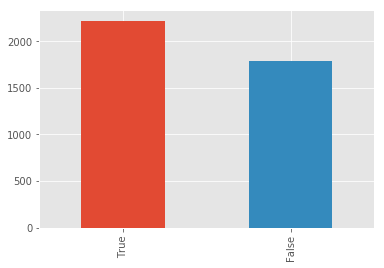

In [35]:

exclusions.metal_salts.value_counts().plot.bar()


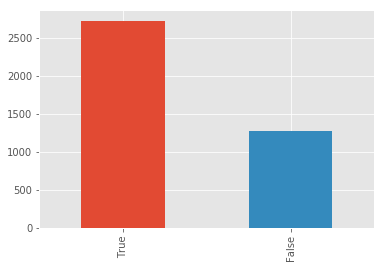

In [36]:
exclusions.inorgs.value_counts().plot.bar()

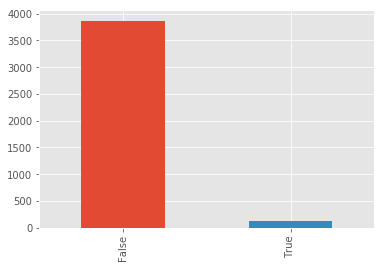

In [37]:
exclusions.inorgP.value_counts().plot.bar()

In [40]:
inorg_filter = []
for x, y, z in list(zip(exclusions['metal_salts'], exclusions['inorgs'], exclusions['inorgP'])):
    if x is True:
        inorg_filter.append('metal_salt')
    elif x is False and y is True:
        inorg_filter.append('inorganic')
    elif z is True:
        inorg_filter.append('inorganic')
    else:
        inorg_filter.append('TTC_NA')
exclusions['inorg_filter'] = inorg_filter

/home/grace/anaconda3/envs/my-mordred/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [46]:
exclusions[exclusions['inorg_filter'] == 'metal_salt'].head()

,casrn,DTXSID,name,smiles,daily_intake,iris_noael,tox_cast_oed_5th,tox_cast_oed_median,tox_tree_ttc,ttc_class,kroes_decision,small_httk,large_cerapp,mark_ttc_class,reason_for_NA,old_ttc_class,metal_salts,inorgs,inorgP,inorg_filter
8,3520-42-1,DTXSID7021235,C.I. Acid Red 52,[Na+].CCN(CC)c1cc2[o+]c3cc(N(CC)CC)c(C)cc3c(-c...,99,NaN,NaN,NaN,0.000003,Genotoxicity Alert,Risk assessment requires compound-specific tox...,NO,YES,NA for TTC,Yes to Q1,NA for TTC,True,True,False,metal_salt
10,16423-68-0,DTXSID7021233,FD&C Red 3,[Na+].[Na+].[O-]C(=O)c1ccccc1-c1c2cc(I)c([O-])...,99,NaN,NaN,NaN,0.000003,Genotoxicity Alert,Risk assessment requires compound-specific tox...,NO,YES,NA for TTC,Yes to Q1,NA for TTC,True,True,False,metal_salt
13,4474-24-2,DTXSID2041705,C.I. Acid Blue 80,[Na+].[Na+].Cc1cc(C)c(c(C)c1Nc1ccc(Nc2c(C)cc(C...,99,NaN,NaN,NaN,0.000003,Genotoxicity Alert,Risk assessment requires compound-specific tox...,NO,YES,NA for TTC,Yes to Q1,NA for TTC,True,True,False,metal_salt
22,518-47-8,DTXSID9025328,Fluorescein sodium,[Na+].[Na+].[O-]c1ccc2c(Oc3cc([O-])ccc3C22OC(=...,99,NaN,NaN,NaN,0.000003,Genotoxicity Alert,Risk assessment requires compound-specific tox...,NO,YES,NA for TTC,Yes to Q1,NA for TTC,True,True,False,metal_salt
25,3567-66-6,DTXSID1044562,D&C Red No. 33,[Na+].[Na+].Nc1cc(cc2cc(c(N=Nc3ccccc3)c(O)c12)...,99,NaN,NaN,NaN,0.000003,Genotoxicity Alert,Risk assessment requires compound-specific tox...,NO,YES,NA for TTC,Yes to Q1,NA for TTC,True,True,False,metal_salt


In [49]:
exclusions.inorg_filter.value_counts()

metal_salt    2220
TTC_NA        1143
inorganic      639
Name: inorg_filter, dtype: int64

In [52]:
639+2220+1143

4002

In [484]:
exclusions[exclusions['inorg_filter'] == 'TTC_NA' ]['reason_for_NA'].value_counts()

Yes to Q1                  900
High Potency Carcinogen    241
Steroid                      2
Name: reason_for_NA, dtype: int64

In [485]:
exclusions[exclusions['inorg_filter'] == 'TTC_applicable' ]['reason_for_NA'].value_counts()

Series([], Name: reason_for_NA, dtype: int64)

In [35]:
xls = pd.ExcelFile(raw_dir+'kroes_gentox_alerts_120619.xlsx')

In [36]:
xls.sheet_names


['kroes_120619']

In [37]:
gentox = xls.parse('kroes_120619')

In [38]:
gentox.head()

,Alerts(genotoxic),Alert_Name,
0,SA1_gen,Acyl halides,
1,SA2_gen,Alkyl (C<5) or benzyl ester of sulphonic or ph...,
2,SA3_gen,N-methylol derivatives,
3,SA4_gen,Monohaloalkene,
4,SA5_gen,S or N mustard,


In [39]:
alert_dict = { k:v for (k,v) in zip(gentox['Alerts(genotoxic)'], gentox['Alert_Name'])}

In [155]:
gentox2 = pd.read_csv(raw_dir+'ISS_carc.csv')

In [156]:
gentox2.head()

,ID,Alert_name
0,SA1_gen,Acyl halides
1,SA2_gen,Alkyl (C<5) or benzyl ester of sulphonic or ph...
2,SA3_gen,N-methylol derivatives
3,SA4_gen,Monohaloalkene
4,SA5_gen,S or N mustard


In [157]:
alert_dict2 = { k:v for (k,v) in zip(gentox2['ID'], gentox2['Alert_name'])}

In [42]:
gen_alerts = pd.read_csv(raw_dir+'LRIexclusions_180719_4toxtree_outputgentox.csv')

In [83]:
alerts = { k:str(v) for (k,v) in zip(gen_alerts['DTXSID'], gen_alerts['mutant.rules.MutantTreeResult#explanation'])}

In [84]:
test = gen_alerts['mutant.rules.MutantTreeResult#explanation'].tolist()[0]
print(test)

,SA1_genN,SA2_genN,SA3_genN,SA4_genN,SA5_genN,SA6_genN,SA7_genN,SA8_genN,SA9_genN,SA11_genN,SA12_genN,SA13_genN,SA14_genN,SA15_genN,SA16_genN,SA18_genN,SA19_genY,SA21_genN,SA22_genN,SA23_genN,SA24_genN,SA25_genN,SA26_genN,SA27_genN,SA28_genN,SA28bis_genY,SA28ter_genN,SA29_genN,SA30_genN,SA37_genN,SA38_genN,SA39_gen_and_nogenN,Genotoxic alert?Y,SA10_genN,aN=NaN,ar-N=CH2N,QSAR6,8 applicable?N,SA17_nogenN,SA20_nogenN,SA31a_nogenN,SA31b_nogenN,SA31c_nogenN,SA39_gen_and_nogenN,SA40_nogenN,SA41_nogenN,SA42_nogenN,SA43_nogenN,SA44_nogenN,SA45_nogenN,SA46_nogenN,SA47_nogenN,SA48_nogenN,SA49_nogenN,SA50_nogenN,SA51_nogenN,SA52_nogenN,SA53_nogenN,SA54_nogenN,SA55_nogenN,SA56_nogenN,Nongenotoxic alert?N


In [85]:
import re

In [86]:
re.findall(r'\w+genY',test)

['SA19_genY', 'SA28bis_genY']

In [87]:
prog = re.compile(r'\w+genY')
result = prog.search(test)

In [89]:
fired_alerts = [m.group(0) for l in alerts.values() for m in [prog.search(l)] if m]

In [107]:
test_alerts = {k: m.group(0) for k,v in alerts.items() for m in [prog.search(v)] if m} 

In [119]:
alerts_fired = pd.DataFrame(list(test_alerts.items()), columns = ['DTXSID', 'Alert'])


In [120]:
alerts_fired.head()

,DTXSID,Alert
0,DTXSID7021235,SA19_genY
1,DTXSID7021233,SA19_genY
2,DTXSID2041705,SA12_genY
3,DTXSID9025328,SA18_genY
4,DTXSID1044562,SA29_genY


In [121]:
def removeandreturn(a):
    c = a[-1]
    a = a[:-1]
    return a

In [123]:
 alerts = [removeandreturn(a) for a in alerts_fired['Alert']]

In [124]:
alerts_fired['Genotox_Alert'] =alerts

In [126]:
alerts_fired.drop(['Alert'], axis = 1, inplace = True)

In [146]:
alerts_fired.Genotox_Alert.head()

0    SA19_gen
1    SA19_gen
2    SA12_gen
3    SA18_gen
4    SA29_gen
Name: Genotox_Alert, dtype: object

In [154]:
alerts_fired.Genotox_Alert.unique()

array(['SA19_gen', 'SA12_gen', 'SA18_gen', 'SA29_gen', 'SA3_gen',
       'SA28bis_gen', 'SA30_gen', 'SA27_gen', 'SA21_gen', 'SA10_gen',
       'SA2_gen', 'SA8_gen', 'SA28_gen', 'SA5_gen', 'SA22_gen',
       'SA11_gen', 'SA7_gen', 'SA16_gen', 'SA17_nogen', 'SA13_gen',
       'SA28ter_gen', 'SA38_gen', 'SA23_gen', 'SA47_nogen', 'SA41_nogen',
       'SA53_nogen', 'SA14_gen', 'SA54_nogen', 'SA31a_nogen', 'SA25_gen',
       'SA15_gen', 'SA26_gen', 'SA52_nogen', 'SA24_gen', 'SA31b_nogen',
       'SA43_nogen', 'SA46_nogen', 'SA31c_nogen', 'SA49_nogen',
       'SA42_nogen', 'SA20_nogen', 'SA40_nogen', 'SA44_nogen',
       'SA56_nogen', 'SA50_nogen'], dtype=object)

In [160]:
len([alert_dict2[k] for k in alerts_fired['Genotox_Alert'] if k in alert_dict2])

1417

In [162]:
fired_alerts_names = [alert_dict2[k] for k in alerts_fired['Genotox_Alert'] if k in alert_dict2]
alerts_fired['Fired_Alert_Names'] = fired_alerts_names

In [163]:
alerts_fired.head()

,DTXSID,Genotox_Alert,Fired_Alert_Names
0,DTXSID7021235,SA19_gen,Heterocyclic Polycyclic Aromatic Hydrocarbons
1,DTXSID7021233,SA19_gen,Heterocyclic Polycyclic Aromatic Hydrocarbons
2,DTXSID2041705,SA12_gen,Quinones
3,DTXSID9025328,SA18_gen,Polycyclic Aromatic Hydrocarbons
4,DTXSID1044562,SA29_gen,Aromatic diazo


In [236]:
#re.findall(r'\w+genY',test)
#[m.group(0) for l in gen_alerts['mutant.rules.MutantTreeResult#explanation'] for m in [prog.findall(l)]]
gen_alerts['mutant.rules.MutantTreeResult#explanation'] = [str(e) for e in gen_alerts['mutant.rules.MutantTreeResult#explanation']]
gen_alert_dict = { k:v for (k,v) in zip(gen_alerts['DTXSID'], gen_alerts['mutant.rules.MutantTreeResult#explanation'])}
#[prog.findall(l) for l in gen_alerts['mutant.rules.MutantTreeResult#explanation'] ]

In [237]:
list_alerts = {k: prog.findall(v) for  k,v in gen_alert_dict.items()} 

In [242]:
list_alerts_df = pd.DataFrame(list(list_alerts.items()), columns = ['DTXSID', 'Alert'])

In [245]:
#[e for i in list_alerts_df['Alert'] for e in i]

In [246]:
list_alerts_df.head()

,DTXSID,Alert
0,DTXSID7021235,"[SA19_genY, SA28bis_genY]"
1,DTXSID7021233,[SA19_genY]
2,DTXSID2041705,"[SA12_genY, SA53_nogenY]"
3,DTXSID9025328,[SA18_genY]
4,DTXSID1044562,[SA29_genY]


In [255]:
out = []
for n, row in list_alerts_df.iterrows():
    for item in row['Alert']:
        row['flat_alert'] =item
        out += [row.copy()]
flat_df = pd.DataFrame(out)

In [256]:
flat_df.head()

,DTXSID,Alert,flat_alert
0,DTXSID7021235,"[SA19_genY, SA28bis_genY]",SA19_genY
0,DTXSID7021235,"[SA19_genY, SA28bis_genY]",SA28bis_genY
1,DTXSID7021233,[SA19_genY],SA19_genY
2,DTXSID2041705,"[SA12_genY, SA53_nogenY]",SA12_genY
2,DTXSID2041705,"[SA12_genY, SA53_nogenY]",SA53_nogenY


In [415]:
len(flat_df)

1637

In [257]:
alerts = [removeandreturn(a) for a in flat_df['flat_alert']]
flat_df['Gentox_alerts'] = alerts

In [259]:
flat_df.drop(['flat_alert'], axis = 1, inplace = True)

In [261]:
alerts_names = [alert_dict2[k] for k in flat_df['Gentox_alerts'] if k in alert_dict2]
flat_df['Fired_Alert_Names'] = alerts_names

In [262]:
flat_df.head()

,DTXSID,Alert,Gentox_alerts,Fired_Alert_Names
0,DTXSID7021235,"[SA19_genY, SA28bis_genY]",SA19_gen,Heterocyclic Polycyclic Aromatic Hydrocarbons
0,DTXSID7021235,"[SA19_genY, SA28bis_genY]",SA28bis_gen,Aromatic mono- and dialkylamine
1,DTXSID7021233,[SA19_genY],SA19_gen,Heterocyclic Polycyclic Aromatic Hydrocarbons
2,DTXSID2041705,"[SA12_genY, SA53_nogenY]",SA12_gen,Quinones
2,DTXSID2041705,"[SA12_genY, SA53_nogenY]",SA53_nogen,Benzensulfonic ethers


In [264]:
flat_df[flat_df['Fired_Alert_Names'].isnull()]

,DTXSID,Alert,Gentox_alerts,Fired_Alert_Names


In [486]:
exclusions_genetox = pd.merge(exclusions,flat_df, on = 'DTXSID', how = 'left')

In [487]:
len(exclusions_genetox)

4222

In [488]:
exclusions_genetox.columns

Index(['casrn', 'DTXSID', 'name', 'smiles', 'daily_intake', 'iris_noael',
       'tox_cast_oed_5th', 'tox_cast_oed_median', 'tox_tree_ttc', 'ttc_class',
       'kroes_decision', 'small_httk', 'large_cerapp', 'mark_ttc_class',
       'reason_for_NA', 'old_ttc_class', 'metal_salts', 'inorgs', 'inorgP',
       'inorg_filter', 'Alert', 'Gentox_alerts', 'Fired_Alert_Names'],
      dtype='object')

In [7]:
xls4 = pd.ExcelFile(raw_dir+'HPC_230719.xlsx')


In [8]:
xls4.sheet_names

['HPC', 'Steroids', 'DLCs', 'Sheet1', 'Sheet6', 'DLCs2', 'DLCs3']

In [9]:
HPC = xls4.parse('HPC')

In [10]:
HPC

,HPC,SMARTS,ISS_Alert
0,Aflatoxin,COC1=C2C3=C(C(=O)OCC3)C(=O)OC2=C2C3C=COC3OC2=C1,NaN
1,Aflatoxin,O=c1ccc2ccccc2(o1),SA30_gen
2,Aflatoxin,O=C1C=Cc2ccccc2O1,SA30_gen
3,Aflatoxin,[#6]1[#6]2[#6]([#8][#6]=1)[#8]c1c2c2c(c(c1)[O]...,NaN
4,Aflatoxin,[#6]1[#6]2[#6]([#8][#6]1)[#8]c1c2c2c(c([#8][#6...,NaN
5,Aflatoxin,[#6]1[#6]2[#6]([#8][#6]1)[#8]c1c2c2c(c(c1)[O][...,NaN
6,Aflatoxin,[#6]1[#6]2[#6]([#8][#6]=1)[#8]c1c2c2c(c(c1)[O]...,NaN
7,Azoxy,NN=O,NaN
8,Azoxy,"[C,#1]N=[NX2][C,#1]",SA14_gen
9,Azoxy,[$(C=[N+]=[N-]);!$(C=[N+]=[N-]=N);!$(C=[N+]=[N...,SA14_gen


In [283]:
hpc_dict = {}
for i,group in HPC.groupby('HPC'):
    key = [name for name in group['HPC'] if name!=' '][0]
    value = set(group['SMARTS'])
    hpc_dict[key]=value

In [284]:
hpc_smarts = {k : [Chem.MolFromSmarts(s) for s in v] for k,v in hpc_dict.items()}

In [285]:
hpc_smarts

{'Aflatoxin': [<rdkit.Chem.rdchem.Mol at 0x7fe0c511db20>,
 'Azoxy': [<rdkit.Chem.rdchem.Mol at 0x7fe0c511d440>,
 'Benzidine': [<rdkit.Chem.rdchem.Mol at 0x7fe0c511d620>],
 'Nitroso': [<rdkit.Chem.rdchem.Mol at 0x7fe0c511dc10>,
  <rdkit.Chem.rdchem.Mol at 0x7fe0c511d120>]}

In [489]:
ex_dict = { k:v for (k,v) in zip(exclusions_genetox['DTXSID'], exclusions_genetox['smiles'])}
ex_smiles = {k : Chem.MolFromSmiles(v) for k,v in ex_dict.items()}

In [490]:
ex_hpc = {x:[k for k, v in hpc_smarts.items() if any([y.HasSubstructMatch(e) for e in v])] for x,y in ex_smiles.items()}

In [491]:
ex_hpc_df = pd.DataFrame(list(ex_hpc.items()), columns = ['DTXSID', 'Flag'])

In [492]:

ex_hpc_df['New_Flag']=[tuple(e) for e in ex_hpc_df['Flag']]

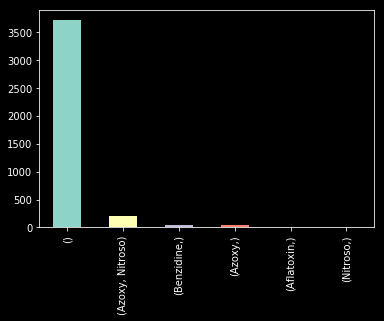

In [493]:
ex_hpc_df.New_Flag.value_counts().plot.bar()
plt.savefig(figures_dir+'HPC_category_counts.png')

In [612]:
ex_hpc_df.New_Flag.value_counts()

()                  3708
(Azoxy, Nitroso)     207
(Benzidine,)          44
(Azoxy,)              36
(Aflatoxin,)           6
(Nitroso,)             1
Name: New_Flag, dtype: int64

In [494]:
exclusions_genetox[exclusions_genetox.Gentox_alerts == 'SA39_gen_and_nogen']


,casrn,DTXSID,name,smiles,daily_intake,iris_noael,tox_cast_oed_5th,tox_cast_oed_median,tox_tree_ttc,ttc_class,...,mark_ttc_class,reason_for_NA,old_ttc_class,metal_salts,inorgs,inorgP,inorg_filter,Alert,Gentox_alerts,Fired_Alert_Names


In [296]:
from rdkit.Chem import Descriptors

In [495]:
logp_pred = {k: Descriptors.MolLogP(v) for k,v in ex_smiles.items()}

In [496]:
logp_pred_df = pd.DataFrame(list(logp_pred.items()), columns = ['DTXSID', 'LogP'])

In [497]:
len(logp_pred_df[logp_pred_df['LogP'] >= 4])

666

In [582]:
DLCs2 = xls4.parse('DLCs2')
DLCs1 = xls4.parse('DLCs')
DLCs3 = xls4.parse('DLCs3')

In [573]:
DLCs2

,ID,SMARTS
0,biphenyl,"c1cc(ccc1)c1ccccc1.[F,Br,Cl,#1].[F,Br,Cl,#1]"
1,dibenzofuran,"c1cccc2oc3ccccc3c12.[F,Br,Cl,#1].[F,Br,Cl,#1]"
2,dibenzodioxin,"c1ccc2Oc3ccccc3Oc2c1.[F,Br,Cl,#1].[F,Br,Cl,#1]"


In [575]:
dlc_dict1 = { k:v for (k,v) in zip(DLCs1['DTXSID'], DLCs1['SMILES'])}
dlc_smiles = {k : Chem.MolFromSmiles(v) for k,v in dlc_dict1.items()}

In [585]:
dlc_dict2 = { k:v for (k,v) in zip(DLCs2['ID'], DLCs2['SMARTS'])}
dlc_smarts = {k : Chem.MolFromSmarts(v) for k,v in dlc_dict2.items()}

In [583]:
#dlc_dict3 = { k:v for (k,v) in zip(DLCs3['ID'], DLCs3['SMARTS'])}
#dlc_smarts1 = {k : Chem.MolFromSmarts(v) for k,v in dlc_dict3.items()}

RDKit ERROR: [11:18:29] SMARTS Parse Error: syntax error for input: '(c1cc(ccc1)c1ccccc1.[F,Br,Cl,#1].[F,Br,Cl,#1])'
RDKit ERROR: [11:18:29] SMARTS Parse Error: syntax error for input: '(c1cccc2oc3ccccc3c12.[F,Br,Cl,#1].[F,Br,Cl,#1])'
RDKit ERROR: [11:18:29] SMARTS Parse Error: syntax error for input: '(c1ccc2Oc3ccccc3Oc2c1.[F,Br,Cl,#1].[F,Br,Cl,#1])'


In [586]:
dlc_hits2 = ({k: Chem.MolToSmiles(v)  for k,v in ex_smiles.items() if any([v.HasSubstructMatch(e) for e in dlc_smarts.values()])})


In [587]:
dlc_hits2_df = pd.DataFrame(list(dlc_hits2 .items()), columns = ['DTXSID', 'DLC_hit'])

In [588]:
len(dlc_hits2_df)

334

In [589]:
dlc_hits2_df .head()

,DTXSID,DLC_hit
0,DTXSID9036804,Nc1c(S(=O)(=O)[O-])cc2cc(S(=O)(=O)[O-])ccc2c1/...
1,DTXSID90145919,Brc1c(Br)c(Br)c2c(oc3c(Br)c(Br)c(Br)c(Br)c32)c1Br
2,DTXSID7073779,Brc1cc2c(oc3c(Br)c(Br)c(Br)c(Br)c32)c(Br)c1Br
3,DTXSID5073870,Brc1cc2oc3c(Br)c(Br)c(Br)cc3c2cc1Br
4,DTXSID60869478,Brc1cc2oc3cc(Br)c(Br)c(Br)c3c2cc1Br


In [611]:
len(logp_pred_df[logp_pred_df.LogP >=4])

666

In [503]:
ex_hpc_df.head()

,DTXSID,Flag,New_Flag
0,DTXSID7021235,[],()
1,DTXSID7021233,[],()
2,DTXSID2041705,[],()
3,DTXSID9025328,[],()
4,DTXSID1044562,[],()


In [514]:
exclusions_genetox[exclusions_genetox.inorg_filter != 'TTC_NA'].head()

,casrn,DTXSID,name,smiles,daily_intake,iris_noael,tox_cast_oed_5th,tox_cast_oed_median,tox_tree_ttc,ttc_class,...,mark_ttc_class,reason_for_NA,old_ttc_class,metal_salts,inorgs,inorgP,inorg_filter,Alert,Gentox_alerts,Fired_Alert_Names
0,3520-42-1,DTXSID7021235,C.I. Acid Red 52,[Na+].CCN(CC)c1cc2[o+]c3cc(N(CC)CC)c(C)cc3c(-c...,99,NaN,NaN,NaN,0.000003,Genotoxicity Alert,...,NA for TTC,Yes to Q1,NA for TTC,True,True,False,metal_salt,"[SA19_genY, SA28bis_genY]",SA19_gen,Heterocyclic Polycyclic Aromatic Hydrocarbons
1,3520-42-1,DTXSID7021235,C.I. Acid Red 52,[Na+].CCN(CC)c1cc2[o+]c3cc(N(CC)CC)c(C)cc3c(-c...,99,NaN,NaN,NaN,0.000003,Genotoxicity Alert,...,NA for TTC,Yes to Q1,NA for TTC,True,True,False,metal_salt,"[SA19_genY, SA28bis_genY]",SA28bis_gen,Aromatic mono- and dialkylamine
2,16423-68-0,DTXSID7021233,FD&C Red 3,[Na+].[Na+].[O-]C(=O)c1ccccc1-c1c2cc(I)c([O-])...,99,NaN,NaN,NaN,0.000003,Genotoxicity Alert,...,NA for TTC,Yes to Q1,NA for TTC,True,True,False,metal_salt,[SA19_genY],SA19_gen,Heterocyclic Polycyclic Aromatic Hydrocarbons
3,4474-24-2,DTXSID2041705,C.I. Acid Blue 80,[Na+].[Na+].Cc1cc(C)c(c(C)c1Nc1ccc(Nc2c(C)cc(C...,99,NaN,NaN,NaN,0.000003,Genotoxicity Alert,...,NA for TTC,Yes to Q1,NA for TTC,True,True,False,metal_salt,"[SA12_genY, SA53_nogenY]",SA12_gen,Quinones
4,4474-24-2,DTXSID2041705,C.I. Acid Blue 80,[Na+].[Na+].Cc1cc(C)c(c(C)c1Nc1ccc(Nc2c(C)cc(C...,99,NaN,NaN,NaN,0.000003,Genotoxicity Alert,...,NA for TTC,Yes to Q1,NA for TTC,True,True,False,metal_salt,"[SA12_genY, SA53_nogenY]",SA53_nogen,Benzensulfonic ethers


In [590]:
temp1 = pd.merge(exclusions_genetox,ex_hpc_df, on = 'DTXSID', how = 'left')

In [591]:
temp2 = pd.merge(temp1, dlc_hits2_df, on = 'DTXSID', how = 'left')

In [592]:
temp3 = pd.merge(temp2, logp_pred_df, on = 'DTXSID', how = 'left')

In [593]:
temp3.columns

Index(['casrn', 'DTXSID', 'name', 'smiles', 'daily_intake', 'iris_noael',
       'tox_cast_oed_5th', 'tox_cast_oed_median', 'tox_tree_ttc', 'ttc_class',
       'kroes_decision', 'small_httk', 'large_cerapp', 'mark_ttc_class',
       'reason_for_NA', 'old_ttc_class', 'metal_salts', 'inorgs', 'inorgP',
       'inorg_filter', 'Alert', 'Gentox_alerts', 'Fired_Alert_Names', 'Flag',
       'New_Flag', 'DLC_hit', 'LogP'],
      dtype='object')

In [594]:
len(temp3)

4222

In [595]:
temp3['genotox_flag'] = np.where(temp3.Gentox_alerts.str.contains('_nogen'), 'non_genotox', 'genotox_alert')

In [596]:
temp3.DLC_hit = temp3.DLC_hit.replace(np.nan, 'None')

In [597]:
temp3[temp3.New_Flag == ()]

,casrn,DTXSID,name,smiles,daily_intake,iris_noael,tox_cast_oed_5th,tox_cast_oed_median,tox_tree_ttc,ttc_class,...,inorgP,inorg_filter,Alert,Gentox_alerts,Fired_Alert_Names,Flag,New_Flag,DLC_hit,LogP,genotox_flag
0,3520-42-1,DTXSID7021235,C.I. Acid Red 52,[Na+].CCN(CC)c1cc2[o+]c3cc(N(CC)CC)c(C)cc3c(-c...,99,NaN,NaN,NaN,0.000003,Genotoxicity Alert,...,False,metal_salt,"[SA19_genY, SA28bis_genY]",SA19_gen,Heterocyclic Polycyclic Aromatic Hydrocarbons,[],(),None,2.65554,genotox_alert
1,3520-42-1,DTXSID7021235,C.I. Acid Red 52,[Na+].CCN(CC)c1cc2[o+]c3cc(N(CC)CC)c(C)cc3c(-c...,99,NaN,NaN,NaN,0.000003,Genotoxicity Alert,...,False,metal_salt,"[SA19_genY, SA28bis_genY]",SA28bis_gen,Aromatic mono- and dialkylamine,[],(),None,2.65554,genotox_alert
2,16423-68-0,DTXSID7021233,FD&C Red 3,[Na+].[Na+].[O-]C(=O)c1ccccc1-c1c2cc(I)c([O-])...,99,NaN,NaN,NaN,0.000003,Genotoxicity Alert,...,False,metal_salt,[SA19_genY],SA19_gen,Heterocyclic Polycyclic Aromatic Hydrocarbons,[],(),None,-1.57170,genotox_alert
3,4474-24-2,DTXSID2041705,C.I. Acid Blue 80,[Na+].[Na+].Cc1cc(C)c(c(C)c1Nc1ccc(Nc2c(C)cc(C...,99,NaN,NaN,NaN,0.000003,Genotoxicity Alert,...,False,metal_salt,"[SA12_genY, SA53_nogenY]",SA12_gen,Quinones,[],(),None,-0.38408,genotox_alert
4,4474-24-2,DTXSID2041705,C.I. Acid Blue 80,[Na+].[Na+].Cc1cc(C)c(c(C)c1Nc1ccc(Nc2c(C)cc(C...,99,NaN,NaN,NaN,0.000003,Genotoxicity Alert,...,False,metal_salt,"[SA12_genY, SA53_nogenY]",SA53_nogen,Benzensulfonic ethers,[],(),None,-0.38408,non_genotox
5,518-47-8,DTXSID9025328,Fluorescein sodium,[Na+].[Na+].[O-]c1ccc2c(Oc3cc([O-])ccc3C22OC(=...,99,NaN,NaN,NaN,0.000003,Genotoxicity Alert,...,False,metal_salt,[SA18_genY],SA18_gen,Polycyclic Aromatic Hydrocarbons,[],(),None,-3.59020,genotox_alert
6,3567-66-6,DTXSID1044562,D&C Red No. 33,[Na+].[Na+].Nc1cc(cc2cc(c(N=Nc3ccccc3)c(O)c12)...,99,NaN,NaN,NaN,0.000003,Genotoxicity Alert,...,False,metal_salt,[SA29_genY],SA29_gen,Aromatic diazo,[],(),None,-3.64080,genotox_alert
7,4368-56-3,DTXSID3044673,C.I. Acid Blue 62,[Na+].Nc1c(cc(NC2CCCCC2)c2C(=O)c3ccccc3C(=O)c1...,99,NaN,NaN,NaN,0.000003,Genotoxicity Alert,...,False,metal_salt,"[SA12_genY, SA53_nogenY]",SA12_gen,Quinones,[],(),None,-0.30310,genotox_alert
8,4368-56-3,DTXSID3044673,C.I. Acid Blue 62,[Na+].Nc1c(cc(NC2CCCCC2)c2C(=O)c3ccccc3C(=O)c1...,99,NaN,NaN,NaN,0.000003,Genotoxicity Alert,...,False,metal_salt,"[SA12_genY, SA53_nogenY]",SA53_nogen,Benzensulfonic ethers,[],(),None,-0.30310,non_genotox
9,17852-99-2,DTXSID2066270,"C.I. Pigment Red 52, calcium salt (1:1)",[Ca++].Cc1cc(N=Nc2c(O)c(cc3ccccc23)C([O-])=O)c...,99,NaN,NaN,NaN,0.000003,Genotoxicity Alert,...,False,metal_salt,"[SA29_genY, SA53_nogenY]",SA29_gen,Aromatic diazo,[],(),None,2.80942,genotox_alert


In [598]:
final_outcome = []
for a,b,c,d in list(zip(temp3['inorg_filter'], temp3['DLC_hit'], temp3['New_Flag'], temp3['genotox_flag'] )):
    if a == 'inorganic':
        final_outcome.append('inorganic')
    elif (a != 'inorganic') & (b != 'None'):
        final_outcome.append('DLC')
    elif (a != 'inorganic') & (b == 'None') & (c != ()) :
        final_outcome.append('HPC')
    elif (a != 'inorganic') & (b == 'None') & (c == ()) & (d == 'genotox_alert'):
        final_outcome.append('Genotoxicity Alert')
    else:
        final_outcome.append('other')


In [599]:
temp3['final_TTC_category'] = final_outcome

In [600]:
temp3.final_TTC_category.value_counts()

other                 2350
inorganic              654
Genotoxicity Alert     541
HPC                    343
DLC                    334
Name: final_TTC_category, dtype: int64

In [601]:
temp4 = temp3.drop_duplicates(['DTXSID'], keep = 'first')

In [602]:
temp4[temp3['DTXSID'] == 'DTXSID7021235']

/home/gpatlewi/anaconda3/envs/my-mordred/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,casrn,DTXSID,name,smiles,daily_intake,iris_noael,tox_cast_oed_5th,tox_cast_oed_median,tox_tree_ttc,ttc_class,...,inorg_filter,Alert,Gentox_alerts,Fired_Alert_Names,Flag,New_Flag,DLC_hit,LogP,genotox_flag,final_TTC_category
0,3520-42-1,DTXSID7021235,C.I. Acid Red 52,[Na+].CCN(CC)c1cc2[o+]c3cc(N(CC)CC)c(C)cc3c(-c...,99,NaN,NaN,NaN,0.000003,Genotoxicity Alert,...,metal_salt,"[SA19_genY, SA28bis_genY]",SA19_gen,Heterocyclic Polycyclic Aromatic Hydrocarbons,[],(),None,2.65554,genotox_alert,Genotoxicity Alert


In [5]:
processed_dir = '/home/grace/Documents/python/ttc_exclusions/data/processed/'


'/home/grace/Documents/python/ttc_exclusions/notebooks'

In [603]:
writer = pd.ExcelWriter(processed_dir+'LRIexclusions_output_240719.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
exclusions_genetox.to_excel(writer, sheet_name = 'exclusions_genetox')
dlc_hits_df.to_excel(writer, sheet_name = 'dlc')
ex_hpc_df.to_excel(writer, sheet_name = 'hpcs')
logp_pred_df.to_excel(writer, sheet_name = 'logP')
temp3.to_excel(writer, sheet_name = 'final')
temp4.to_excel(writer, sheet_name = 'final_nodups')


writer.save()

In [605]:
temp4.final_TTC_category.value_counts()

other                 2249
inorganic              639
Genotoxicity Alert     487
DLC                    334
HPC                    293
Name: final_TTC_category, dtype: int64

In [606]:
len(temp4)

4002